# Convolutional Autoencoder using pytorch
Following the example from: <br>
https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [2]:
# please specify data path
datapath = '../data/MNIST/raw'

### Import MNIST dataset and prepare data

In [3]:
train_dataset = torchvision.datasets.MNIST(datapath, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(datapath, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

### Define convolutional autoencoder
It will be composed of two classes: one for the encoder and one for the decoder. The encoder will contain three convolutional layers and two fully connected layers. Some batch norm layers are added as regularizers. The decoder will have the same architecture but in inverse order.

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [8]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [9]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253613
	 partial train loss (single batch): 0.246079
	 partial train loss (single batch): 0.240337
	 partial train loss (single batch): 0.235746
	 partial train loss (single batch): 0.231942
	 partial train loss (single batch): 0.228258
	 partial train loss (single batch): 0.224885
	 partial train loss (single batch): 0.222290
	 partial train loss (single batch): 0.220346
	 partial train loss (single batch): 0.217299
	 partial train loss (single batch): 0.215631
	 partial train loss (single batch): 0.213910
	 partial train loss (single batch): 0.211336
	 partial train loss (single batch): 0.209054
	 partial train loss (single batch): 0.206979
	 partial train loss (single batch): 0.204952
	 partial train loss (single batch): 0.203222
	 partial train loss (single batch): 0.201116
	 partial train loss (single batch): 0.198687
	 partial train loss (single batch): 0.197218
	 partial train loss (single batch): 0.195494
	 partial train loss (single batch

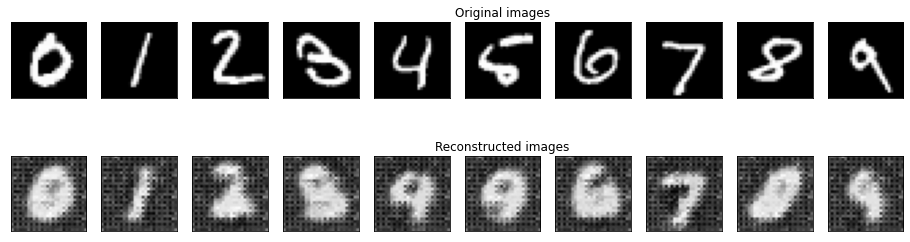

	 partial train loss (single batch): 0.066184
	 partial train loss (single batch): 0.067048
	 partial train loss (single batch): 0.065515
	 partial train loss (single batch): 0.065231
	 partial train loss (single batch): 0.065454
	 partial train loss (single batch): 0.064731
	 partial train loss (single batch): 0.064072
	 partial train loss (single batch): 0.064687
	 partial train loss (single batch): 0.064052
	 partial train loss (single batch): 0.065076
	 partial train loss (single batch): 0.063421
	 partial train loss (single batch): 0.063349
	 partial train loss (single batch): 0.063806
	 partial train loss (single batch): 0.063108
	 partial train loss (single batch): 0.063255
	 partial train loss (single batch): 0.062763
	 partial train loss (single batch): 0.063565
	 partial train loss (single batch): 0.062651
	 partial train loss (single batch): 0.062964
	 partial train loss (single batch): 0.061780
	 partial train loss (single batch): 0.061665
	 partial train loss (single batch

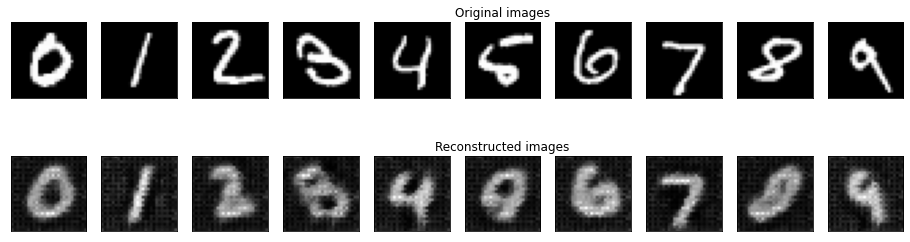

	 partial train loss (single batch): 0.045749
	 partial train loss (single batch): 0.047176
	 partial train loss (single batch): 0.046127
	 partial train loss (single batch): 0.045596
	 partial train loss (single batch): 0.045857
	 partial train loss (single batch): 0.045465
	 partial train loss (single batch): 0.045170
	 partial train loss (single batch): 0.045434
	 partial train loss (single batch): 0.045155
	 partial train loss (single batch): 0.046339
	 partial train loss (single batch): 0.044519
	 partial train loss (single batch): 0.044673
	 partial train loss (single batch): 0.045905
	 partial train loss (single batch): 0.044992
	 partial train loss (single batch): 0.045395
	 partial train loss (single batch): 0.044836
	 partial train loss (single batch): 0.045527
	 partial train loss (single batch): 0.045017
	 partial train loss (single batch): 0.045166
	 partial train loss (single batch): 0.044313
	 partial train loss (single batch): 0.044538
	 partial train loss (single batch

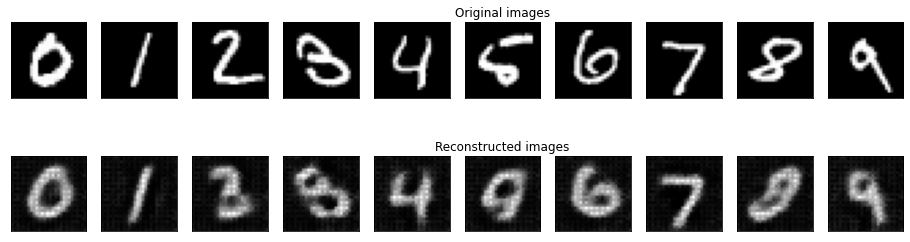

	 partial train loss (single batch): 0.036847
	 partial train loss (single batch): 0.038010
	 partial train loss (single batch): 0.037055
	 partial train loss (single batch): 0.036983
	 partial train loss (single batch): 0.036511
	 partial train loss (single batch): 0.036679
	 partial train loss (single batch): 0.036762
	 partial train loss (single batch): 0.036313
	 partial train loss (single batch): 0.036455
	 partial train loss (single batch): 0.037928
	 partial train loss (single batch): 0.035556
	 partial train loss (single batch): 0.035520
	 partial train loss (single batch): 0.037254
	 partial train loss (single batch): 0.036887
	 partial train loss (single batch): 0.036634
	 partial train loss (single batch): 0.036359
	 partial train loss (single batch): 0.036761
	 partial train loss (single batch): 0.036736
	 partial train loss (single batch): 0.036346
	 partial train loss (single batch): 0.035656
	 partial train loss (single batch): 0.036580
	 partial train loss (single batch

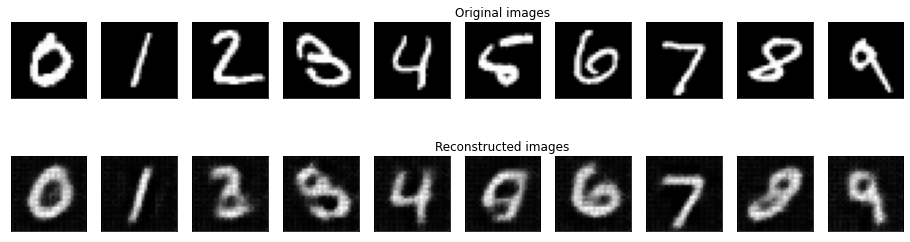

	 partial train loss (single batch): 0.032856
	 partial train loss (single batch): 0.033827
	 partial train loss (single batch): 0.033367
	 partial train loss (single batch): 0.033447
	 partial train loss (single batch): 0.032741
	 partial train loss (single batch): 0.032950
	 partial train loss (single batch): 0.033108
	 partial train loss (single batch): 0.032436
	 partial train loss (single batch): 0.032874
	 partial train loss (single batch): 0.034323
	 partial train loss (single batch): 0.031825
	 partial train loss (single batch): 0.031617
	 partial train loss (single batch): 0.033464
	 partial train loss (single batch): 0.033239
	 partial train loss (single batch): 0.033022
	 partial train loss (single batch): 0.032689
	 partial train loss (single batch): 0.032655
	 partial train loss (single batch): 0.033226
	 partial train loss (single batch): 0.032726
	 partial train loss (single batch): 0.032092
	 partial train loss (single batch): 0.033164
	 partial train loss (single batch

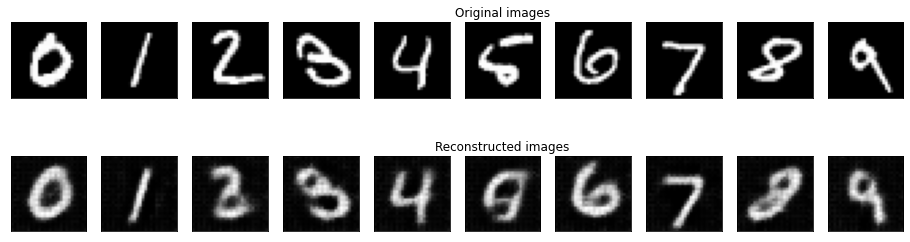

	 partial train loss (single batch): 0.031021
	 partial train loss (single batch): 0.031781
	 partial train loss (single batch): 0.031618
	 partial train loss (single batch): 0.031666
	 partial train loss (single batch): 0.030991
	 partial train loss (single batch): 0.031207
	 partial train loss (single batch): 0.031346
	 partial train loss (single batch): 0.030464
	 partial train loss (single batch): 0.031015
	 partial train loss (single batch): 0.032430
	 partial train loss (single batch): 0.029992
	 partial train loss (single batch): 0.029740
	 partial train loss (single batch): 0.031656
	 partial train loss (single batch): 0.031477
	 partial train loss (single batch): 0.031361
	 partial train loss (single batch): 0.030851
	 partial train loss (single batch): 0.030816
	 partial train loss (single batch): 0.031387
	 partial train loss (single batch): 0.031080
	 partial train loss (single batch): 0.030264
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch

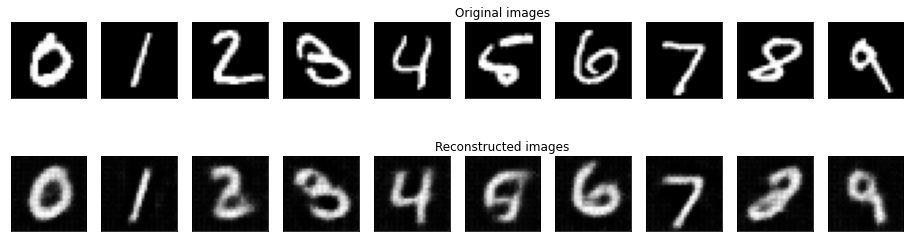

	 partial train loss (single batch): 0.029915
	 partial train loss (single batch): 0.030749
	 partial train loss (single batch): 0.030639
	 partial train loss (single batch): 0.030614
	 partial train loss (single batch): 0.030153
	 partial train loss (single batch): 0.030270
	 partial train loss (single batch): 0.030093
	 partial train loss (single batch): 0.029422
	 partial train loss (single batch): 0.029985
	 partial train loss (single batch): 0.031373
	 partial train loss (single batch): 0.029149
	 partial train loss (single batch): 0.028591
	 partial train loss (single batch): 0.030502
	 partial train loss (single batch): 0.030474
	 partial train loss (single batch): 0.030402
	 partial train loss (single batch): 0.029839
	 partial train loss (single batch): 0.029757
	 partial train loss (single batch): 0.030366
	 partial train loss (single batch): 0.030161
	 partial train loss (single batch): 0.029246
	 partial train loss (single batch): 0.030537
	 partial train loss (single batch

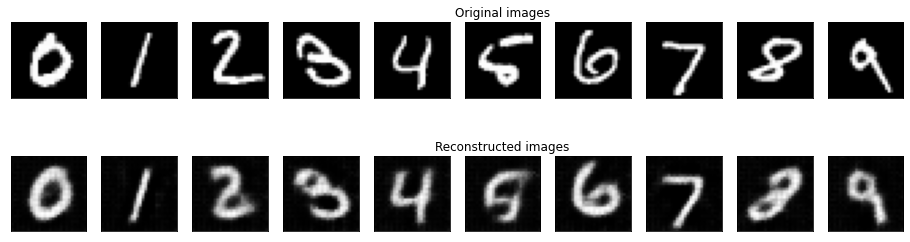

	 partial train loss (single batch): 0.029238
	 partial train loss (single batch): 0.030039
	 partial train loss (single batch): 0.029905
	 partial train loss (single batch): 0.029891
	 partial train loss (single batch): 0.029544
	 partial train loss (single batch): 0.029550
	 partial train loss (single batch): 0.029366
	 partial train loss (single batch): 0.028598
	 partial train loss (single batch): 0.029259
	 partial train loss (single batch): 0.030515
	 partial train loss (single batch): 0.028631
	 partial train loss (single batch): 0.027908
	 partial train loss (single batch): 0.029760
	 partial train loss (single batch): 0.029843
	 partial train loss (single batch): 0.029798
	 partial train loss (single batch): 0.029044
	 partial train loss (single batch): 0.029201
	 partial train loss (single batch): 0.029851
	 partial train loss (single batch): 0.029501
	 partial train loss (single batch): 0.028468
	 partial train loss (single batch): 0.029873
	 partial train loss (single batch

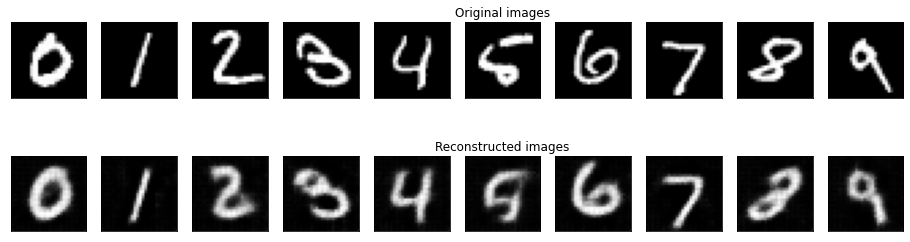

	 partial train loss (single batch): 0.028668
	 partial train loss (single batch): 0.029543
	 partial train loss (single batch): 0.029405
	 partial train loss (single batch): 0.029359
	 partial train loss (single batch): 0.028952
	 partial train loss (single batch): 0.029057
	 partial train loss (single batch): 0.028707
	 partial train loss (single batch): 0.028017
	 partial train loss (single batch): 0.028825
	 partial train loss (single batch): 0.029924
	 partial train loss (single batch): 0.028152
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.029172
	 partial train loss (single batch): 0.029247
	 partial train loss (single batch): 0.029295
	 partial train loss (single batch): 0.028532
	 partial train loss (single batch): 0.028745
	 partial train loss (single batch): 0.029444
	 partial train loss (single batch): 0.028948
	 partial train loss (single batch): 0.027943
	 partial train loss (single batch): 0.029422
	 partial train loss (single batch

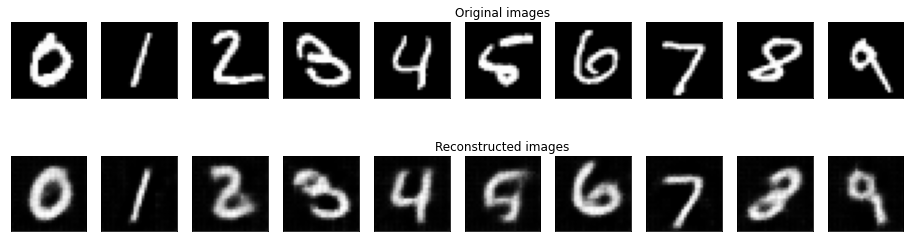

	 partial train loss (single batch): 0.028286
	 partial train loss (single batch): 0.029197
	 partial train loss (single batch): 0.028953
	 partial train loss (single batch): 0.028928
	 partial train loss (single batch): 0.028550
	 partial train loss (single batch): 0.028803
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch): 0.027549
	 partial train loss (single batch): 0.028495
	 partial train loss (single batch): 0.029473
	 partial train loss (single batch): 0.027703
	 partial train loss (single batch): 0.027045
	 partial train loss (single batch): 0.028851
	 partial train loss (single batch): 0.028846
	 partial train loss (single batch): 0.028925
	 partial train loss (single batch): 0.028120
	 partial train loss (single batch): 0.028265
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.028640
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.029023
	 partial train loss (single batch

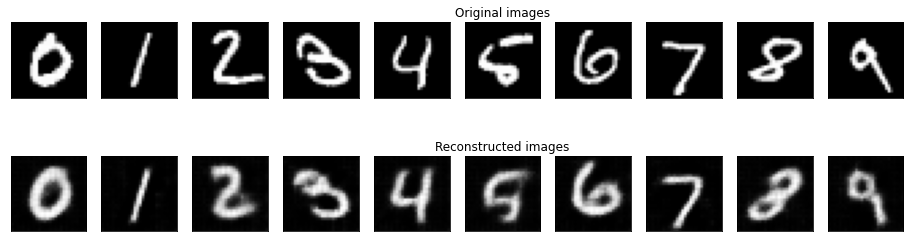

	 partial train loss (single batch): 0.027953
	 partial train loss (single batch): 0.028905
	 partial train loss (single batch): 0.028628
	 partial train loss (single batch): 0.028650
	 partial train loss (single batch): 0.028256
	 partial train loss (single batch): 0.028613
	 partial train loss (single batch): 0.027940
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.029156
	 partial train loss (single batch): 0.027460
	 partial train loss (single batch): 0.026769
	 partial train loss (single batch): 0.028500
	 partial train loss (single batch): 0.028473
	 partial train loss (single batch): 0.028621
	 partial train loss (single batch): 0.027728
	 partial train loss (single batch): 0.027980
	 partial train loss (single batch): 0.028575
	 partial train loss (single batch): 0.028305
	 partial train loss (single batch): 0.027226
	 partial train loss (single batch): 0.028754
	 partial train loss (single batch

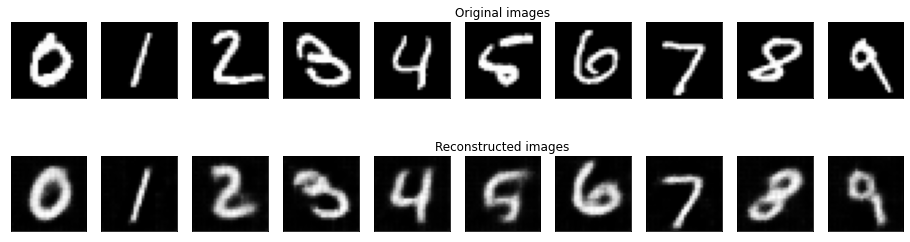

	 partial train loss (single batch): 0.027661
	 partial train loss (single batch): 0.028587
	 partial train loss (single batch): 0.028263
	 partial train loss (single batch): 0.028370
	 partial train loss (single batch): 0.027895
	 partial train loss (single batch): 0.028366
	 partial train loss (single batch): 0.027584
	 partial train loss (single batch): 0.026884
	 partial train loss (single batch): 0.027866
	 partial train loss (single batch): 0.028875
	 partial train loss (single batch): 0.027176
	 partial train loss (single batch): 0.026535
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.028166
	 partial train loss (single batch): 0.028392
	 partial train loss (single batch): 0.027471
	 partial train loss (single batch): 0.027586
	 partial train loss (single batch): 0.028261
	 partial train loss (single batch): 0.028019
	 partial train loss (single batch): 0.026859
	 partial train loss (single batch): 0.028445
	 partial train loss (single batch

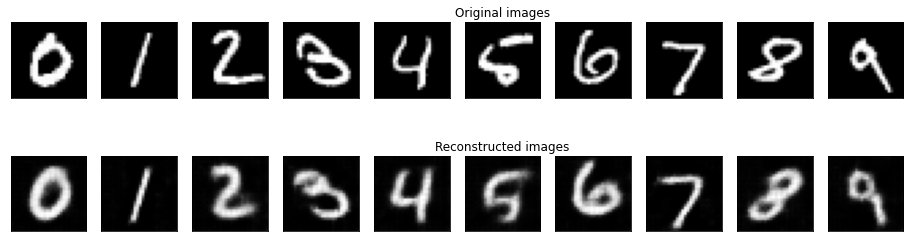

	 partial train loss (single batch): 0.027353
	 partial train loss (single batch): 0.028408
	 partial train loss (single batch): 0.028026
	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.027601
	 partial train loss (single batch): 0.028166
	 partial train loss (single batch): 0.027362
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.027694
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.026368
	 partial train loss (single batch): 0.028001
	 partial train loss (single batch): 0.027930
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.027365
	 partial train loss (single batch): 0.027358
	 partial train loss (single batch): 0.028060
	 partial train loss (single batch): 0.027811
	 partial train loss (single batch): 0.026659
	 partial train loss (single batch): 0.028321
	 partial train loss (single batch

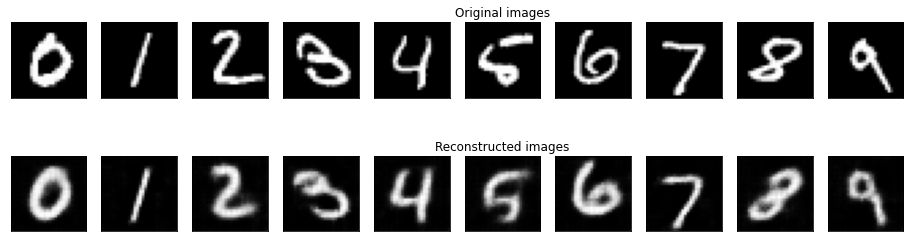

	 partial train loss (single batch): 0.027172
	 partial train loss (single batch): 0.028229
	 partial train loss (single batch): 0.027745
	 partial train loss (single batch): 0.027885
	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.027970
	 partial train loss (single batch): 0.027135
	 partial train loss (single batch): 0.026325
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch): 0.028330
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.026189
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.027870
	 partial train loss (single batch): 0.027189
	 partial train loss (single batch): 0.027120
	 partial train loss (single batch): 0.027788
	 partial train loss (single batch): 0.027534
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch

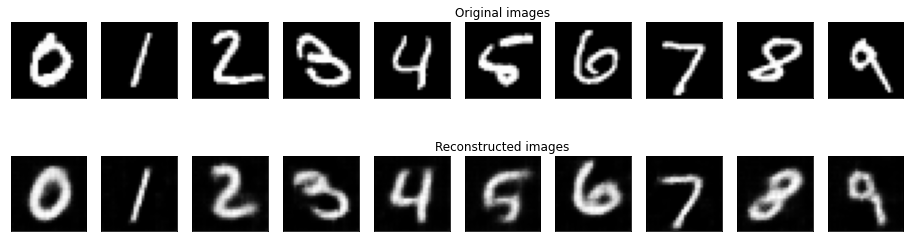

	 partial train loss (single batch): 0.026885
	 partial train loss (single batch): 0.028012
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.027651
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.027795
	 partial train loss (single batch): 0.026983
	 partial train loss (single batch): 0.026078
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.028114
	 partial train loss (single batch): 0.026664
	 partial train loss (single batch): 0.025995
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.027512
	 partial train loss (single batch): 0.027615
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.026933
	 partial train loss (single batch): 0.027637
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.027763
	 partial train loss (single batch

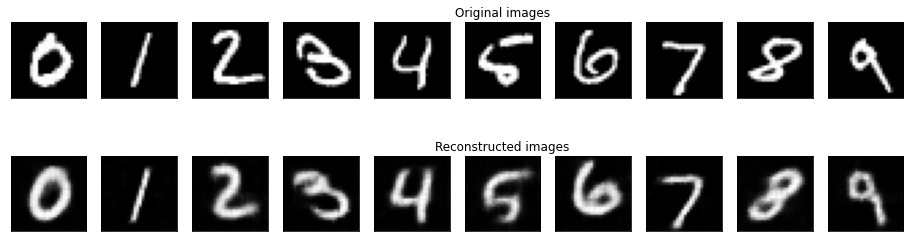

In [10]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

Now the model is trained and we want to do a final evaluation on the test set。

In [11]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.027448400855064392

We can also observe how the reconstruction losses decrease over the epochs.

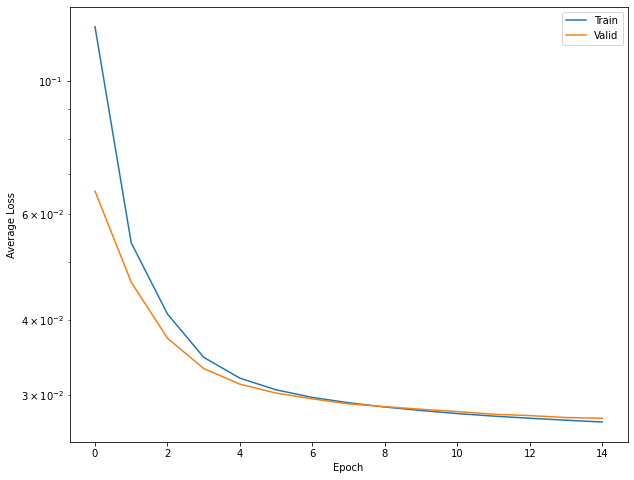

In [12]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

Generate new samples from the random latent code.

tensor([-0.1573,  0.2523,  0.2037, -0.0906])
tensor([0.6783, 0.7802, 0.7382, 0.5158])


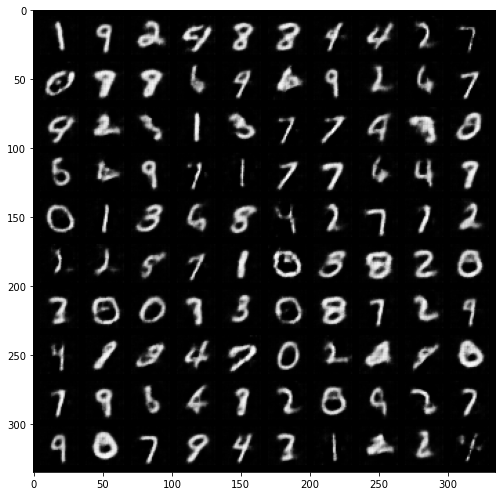

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

Visualize the latent space with t-SNE.

In [14]:
encoded_samples = []
for sample in tqdm.tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:05<00:00, 1888.17it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -0.813934         2.473015        -0.648625         0.713881   
1           -0.621408        -0.001176         1.151936         0.205559   
2            0.235351         1.582466         0.784816        -0.569134   
3           -0.027849        -0.957033         0.117714        -0.313467   
4            0.896346         0.166405        -0.802515         0.196111   
...               ...              ...              ...              ...   
9995        -1.830148         0.436944         1.529737        -0.198430   
9996        -0.397724        -0.340826         0.739423         0.210124   
9997         0.477881         0.986325        -0.677286        -0.494398   
9998        -0.200690         0.091395        -0.215806        -0.983428   
9999         0.661623        -0.818658         0.166691        -0.346638   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [15]:
# Let’s plot the latent space representation using plotly express library:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In order to have an easier representation to read, we can apply a dimensionality reduction, called t-SNE , to visualize the latent code in a 2d space.

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/home/yangliu/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/yangliu/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

